In [99]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import pandas as pd
import os
import glob
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import torch
from torch.utils.data import Dataset,DataLoader
import  cv2
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_auc_score
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.manual_seed(42)

PyTorch Version:  1.10.2
Torchvision Version:  0.11.3


In [100]:
#Data_dir = "./data/plant-pathology-2020-fgvc7/images/"
#dataframe = pd.read_csv("./data/plant-pathology-2020-fgvc7/train.csv")
#test_df = pd.read_csv("./data/plant-pathology-2020-fgvc7/test.csv")
#submit = pd.read_csv("./data/plant-pathology-2020-fgvc7/sample_submission.csv")

Data_dir2 = "d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves"

In [101]:
os.chdir("d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves")

data = []
for index, file in enumerate(glob.glob("*.jpg"), start=1):
    data.append(file)
    
df = pd.DataFrame(data, columns=['test'])
print(df)

      test
0    1.jpg
1   10.jpg
2   11.jpg
3   12.jpg
4   13.jpg
..     ...
70  73.jpg
71  74.jpg
72  75.jpg
73   8.jpg
74   9.jpg

[75 rows x 1 columns]


In [102]:
class Plant_dataset(Dataset):
    
    def __init__(self,df,data_dir,transform,train=True,label=None):
        self.len = df.shape[0]
        self.dir = data_dir
        self.transform=transform
        self.df = df
        self.train=train
        self.label=label
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        img_pth = os.path.join(self.dir,self.df['test'].loc[idx])
        image = mpimg.imread(img_pth)
        image = cv2.resize(image,(224,224))
        if self.transform:
            image = self.transform(image)
        if(self.train==True):
            labels =np.argmax(self.label.loc[idx,:].values)
        else:
            return image
        return image,labels
    

In [103]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
test_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])

In [104]:
print(df)
test_dataset = Plant_dataset(df,Data_dir2,transform=test_transf,train=False)

      test
0    1.jpg
1   10.jpg
2   11.jpg
3   12.jpg
4   13.jpg
..     ...
70  73.jpg
71  74.jpg
72  75.jpg
73   8.jpg
74   9.jpg

[75 rows x 1 columns]


'\npth = os.path.join("d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves","23.jpg")\nim = mpimg.imread(pth)\nim = cv2.resize(im, (100,100))\nplt.imshow(im, cmap="hot")\n'

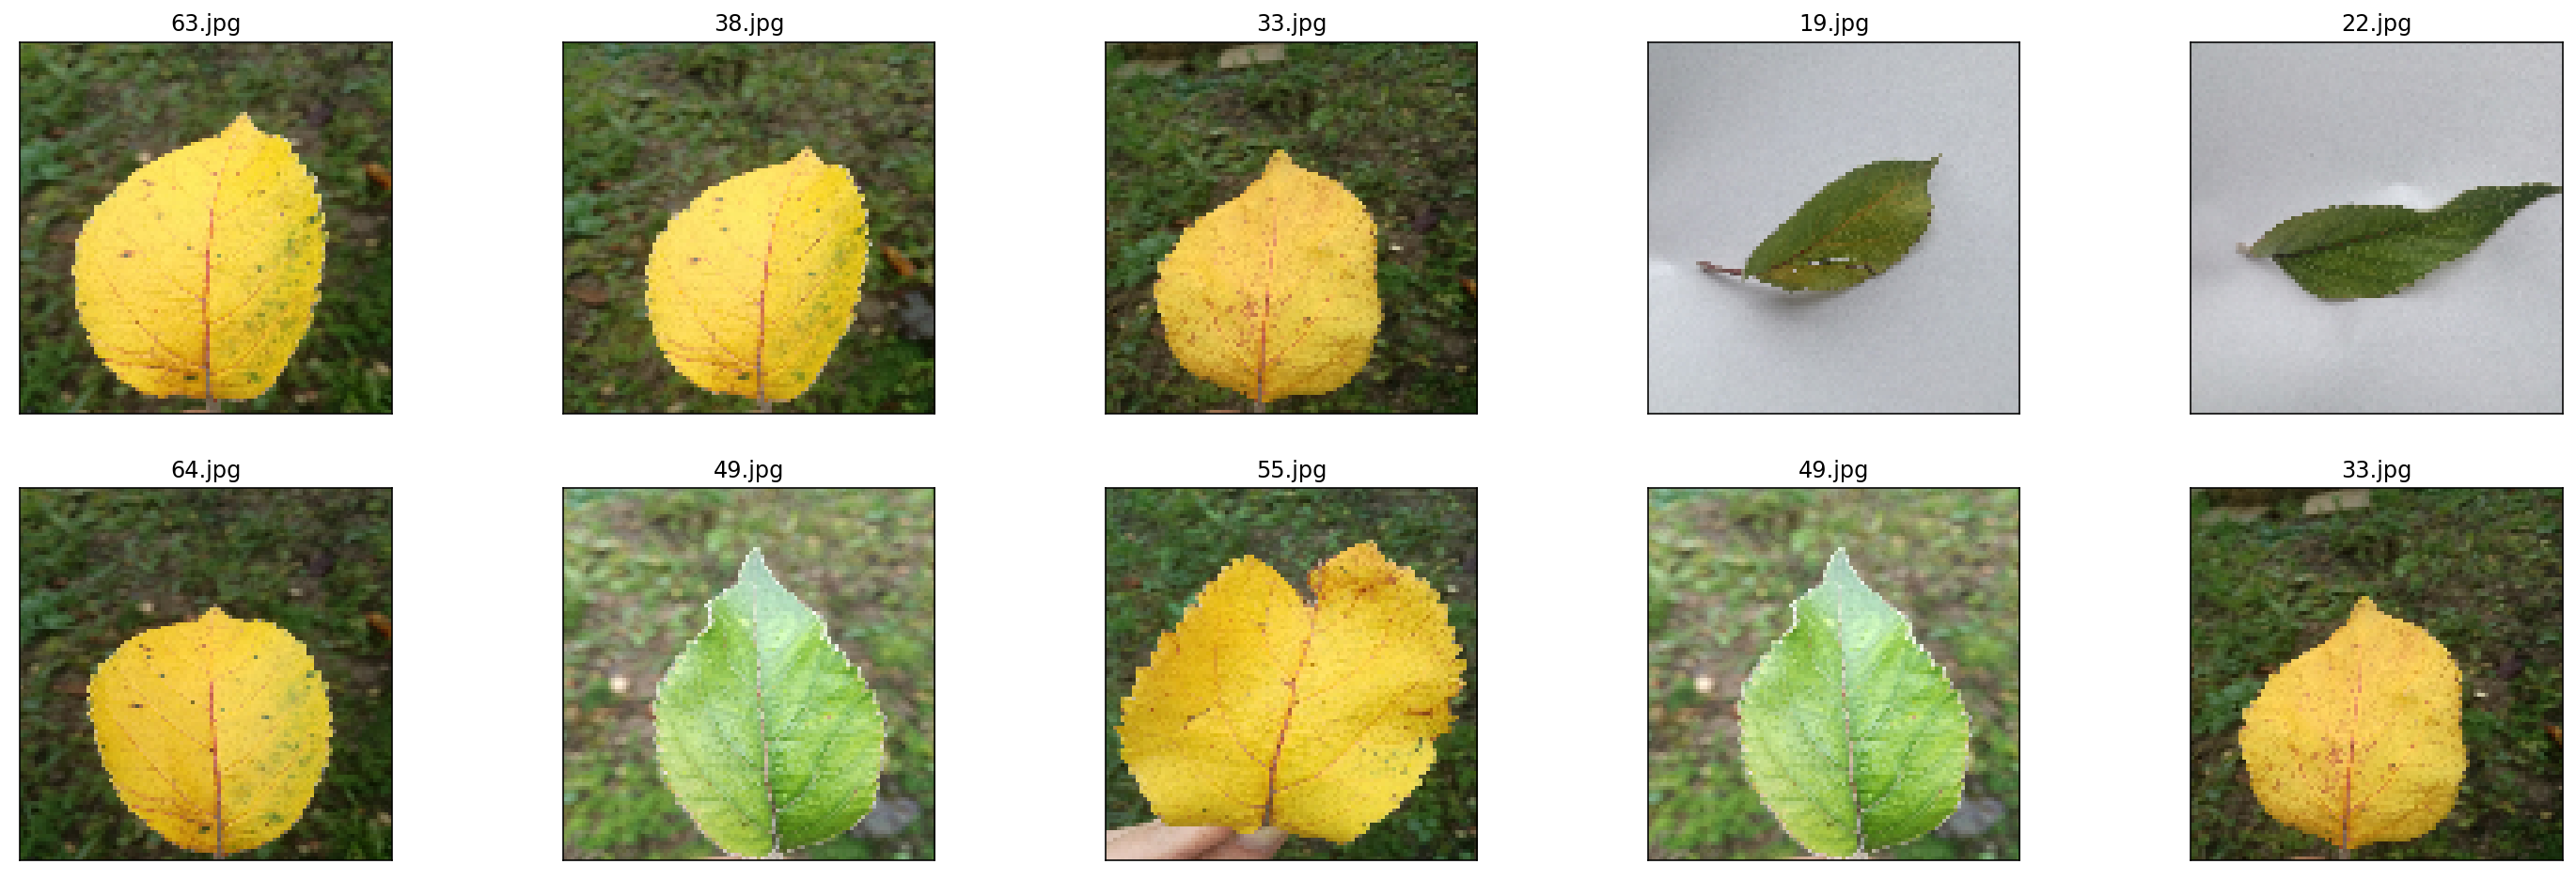

In [106]:
col = df.columns
fig = plt.figure(figsize=(25, 8))

for i, idx in enumerate(np.random.choice(df.index, 10)):
    ax = fig.add_subplot(2, 10//2, i+1, xticks=[], yticks=[])
    #pth = os.path.join("./data/Alex_leaves/",df.test[idx])
    pth = os.path.join("d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves",df.test[idx])
    im = mpimg.imread(pth)
    im = cv2.resize(im, (100, 100)) 
    plt.imshow(im, cmap="hot")
    lab =df.test[idx]
    ax.set_title(lab)
"""
pth = os.path.join("d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves","23.jpg")
im = mpimg.imread(pth)
im = cv2.resize(im, (100,100))
plt.imshow(im, cmap="hot")
"""

In [107]:
batch_size=32
testloader = DataLoader(dataset=test_dataset,batch_size=batch_size)

In [108]:
model_name = "densenet"
num_classes = 4
num_epochs = 10
feature_extract = False
learning_rate = 0.0008

In [109]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [110]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [111]:
#PATH = 'Finetuning_densenet_heavy.pth'
PATH = 'd:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/Finetuning_densenet_heavy.pth'

#model_ft = model_ft.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model_ft.load_state_dict(torch.load(PATH))
#model.eval()
#model_ft = torch.load(PATH)
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [112]:
#torch.save(model_ft, 'whole_model_heavy2.pth')
PATH = 'd:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/whole_model_heavy2.pth'

model_ft2 = torch.load(PATH)
print(model_ft2)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [113]:
#print(testloader)
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

ValueError: too many values to unpack (expected 2)

In [ ]:
"""
model = CNNet(5)
checkpoint = torch.load(Path('C:/Users/Aeryes/PycharmProjects/simplecnn/src/19.model'))
model.load_state_dict(checkpoint)
trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

image = Image.open(Path('C:/Users/Aeryes/PycharmProjects/simplecnn/images/pretrain_classify/rose_classify.jpg'))

input = trans(image)

input = input.view(1, 3, 32,32)
"""
idx = 2
pth = os.path.join("d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves",df.test[idx])
im = mpimg.imread(pth)
im = cv2.resize(im, (100, 100)) 
plt.imshow(im, cmap="hot")
lab =df.test[idx]
ax.set_title(lab)

# Iterate over data.
for input, labels in enumerate(testloader):
    #data, target = sample['data'].cuda(), sample['target'].cuda()
    #prediction = int(torch.max(output.data, 1)[1].numpy())
    #print(prediction)
    output = model_ft2(input)
    
    prediction = int(torch.max(output.data, 1)[1].numpy())
    print(prediction)

#input, labels = testloader

#optimizer.zero_grad()


"""
output = model(input)

prediction = int(torch.max(output.data, 1)[1].numpy())
print(prediction)

if (prediction == 0):
    print ('daisy')
if (prediction == 1):
    print ('dandelion')
if (prediction == 2):
    print ('rose')
if (prediction == 3):
    print ('sunflower')
if (prediction == 4):
    print ('tulip')
"""

tensor([[-10.4857,  -0.1818,  11.1656,  -9.7882]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[3.9532e-10, 1.1800e-05, 9.9999e-01, 7.9407e-10]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Predicted class is: classe_2


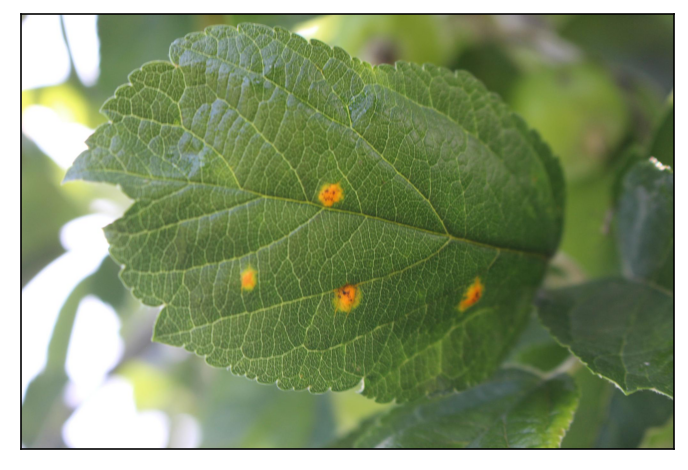

In [136]:
# Add the path to torchvision - change as needed
#import sys
#sys.path.insert(0, '/home/mircea/python-envs/env/lib/python3.6/site-packages/vision')

# Choose an image to pass through the model
test_image = "d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves/class2.jpg"

# Imports
#import json
#import numpy as np
#from torchvision import datasets, models, transforms
#from PIL import Image

# Import matplotlib and configure it for pretty inline plots
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Prepare the labels
#with open("imagenet-simple-labels.json") as f:
#    labels = json.load(f)
labels = ['classe_0','classe_1','classe_2','classe_3']

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
test_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])
# Load the image
image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image)
image = test_transf(image).unsqueeze(0).cuda()
# Download the model if it's not there already. It will take a bit on the first run, after that it's fast

# Send the model to the GPU 
model_ft2.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
model_ft2.eval();

# Get the 1000-dimensional model output
out = model_ft2(image)
print(out)
m = nn.Softmax(dim=1)
output = m(out)
print(output)
# Find the predicted class
print("Predicted class is: {}".format(labels[out.argmax()]))

TypeError: conv2d() received an invalid combination of arguments - got (JpegImageFile, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mJpegImageFile[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mJpegImageFile[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


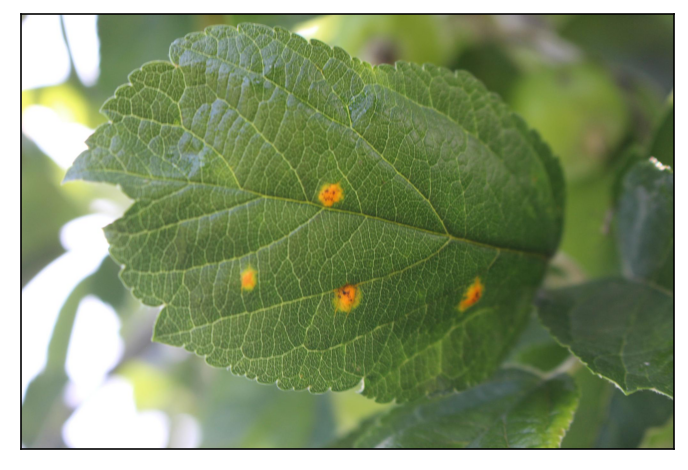

In [123]:
# Add the path to torchvision - change as needed
#import sys
#sys.path.insert(0, '/home/mircea/python-envs/env/lib/python3.6/site-packages/vision')

# Choose an image to pass through the model
test_image = "d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves/class2.jpg"
dire = "d:/Users/jonat/TelecomParis/PACT/Projet/projet/IA/data/Alex_leaves/"
picture = "class2.jpg"

# Imports
#import json
#import numpy as np
#from torchvision import datasets, models, transforms
#from PIL import Image

# Import matplotlib and configure it for pretty inline plots
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Prepare the labels
#with open("imagenet-simple-labels.json") as f:
#    labels = json.load(f)
labels = ['classe_0','classe_1','classe_2','classe_3']

img_pth = os.path.join(dire,picture)
image = mpimg.imread(img_pth)
image = cv2.resize(image,(224,224))

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
test_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])

image = test_transf(image).unsqueeze(0).cuda()


# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
test_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])
# Load the image
image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
#image = data_transform(image)
#image = test_transf(image).unsqueeze(0).cuda()
# Download the model if it's not there already. It will take a bit on the first run, after that it's fast

# Send the model to the GPU 
model_ft2.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
model_ft2.eval();

# Get the 1000-dimensional model output
out = model_ft2(image)
# Find the predicted class
print("Predicted class is: {}".format(labels[out.argmax()]))

In [119]:
input = df['test']
print(input)

0      1.jpg
1     10.jpg
2     11.jpg
3     12.jpg
4     13.jpg
       ...  
70    73.jpg
71    74.jpg
72    75.jpg
73     8.jpg
74     9.jpg
Name: test, Length: 75, dtype: object


In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
def prediction(model,dataloader):
    model.eval()
    test_preds = None
    for i,batch in enumerate(dataloader):
        image = batch
        image = image.to(device)
        with torch.no_grad():
            out = model(image)
            print(out)
            print(image)
            if test_preds is None:
                test_preds = out.data.cpu()
            else:
                test_preds = torch.cat((test_preds, out.data.cpu()), dim=0)
    return test_preds

test_pred = prediction(model_ft2,testloader)

tensor([[-0.5511, -0.8983,  1.6901, -1.7338],
        [ 2.2852, -1.1024, -1.1452, -0.2309],
        [ 0.9497, -0.8686, -0.2184, -0.1840],
        [ 1.0179, -0.8477, -0.2586, -0.2193],
        [ 0.9410, -1.0253,  0.2471, -1.0541],
        [ 1.9512, -1.3135, -0.8651,  0.0317],
        [-0.5245, -0.6574,  1.3916, -1.6198],
        [ 2.6120, -2.0082, -1.1403,  0.3668],
        [ 2.3695, -1.5960, -1.3312,  0.5004],
        [ 3.4263, -1.8886, -1.4783, -0.3813],
        [ 2.2201, -1.5859, -1.3188,  0.5482],
        [-0.0103, -0.8770,  1.0383, -1.1912],
        [ 2.7198, -1.2816, -1.5288, -0.5785],
        [ 3.7459, -2.2309, -1.5877, -0.3794],
        [ 3.2639, -1.8104, -1.5074, -0.2170],
        [ 3.7782, -2.2703, -1.4830, -0.4490],
        [ 3.7790, -1.9393, -1.6630, -0.5663],
        [ 4.3111, -2.2661, -1.7433, -0.7580],
        [ 1.4455, -1.6381, -1.2376,  0.8004],
        [ 1.6717, -1.4385, -1.1506,  0.5067],
        [ 0.4379, -1.5492,  0.2448, -0.1804],
        [ 1.0571, -1.5400, -0.6023

tensor([[ 4.1731e-01, -9.6016e-01, -1.0783e+00,  6.4140e-01],
        [-3.0333e-02, -8.5491e-01,  1.1464e+00, -1.5720e+00],
        [ 1.0195e+00, -4.7009e-01, -1.0884e+00,  4.2615e-01],
        [-2.9699e+00, -7.6973e-01, -4.6569e+00,  6.0069e+00],
        [-2.1958e+00, -2.2743e+00, -4.8806e+00,  7.1701e+00],
        [-8.5858e-01, -5.5229e-01, -2.6037e+00,  2.9870e+00],
        [-3.7164e+00, -3.9647e-01, -5.2501e+00,  6.5144e+00],
        [-2.3168e+00, -1.1684e+00, -4.2751e+00,  5.4363e+00],
        [ 2.2169e+00, -1.5204e+00, -2.2182e+00,  8.1422e-01],
        [ 2.5999e+00, -2.3778e+00, -1.9617e+00,  1.2313e+00],
        [ 1.9869e+00, -3.5072e+00, -2.4661e+00,  2.9595e+00],
        [ 2.2794e+00, -3.3856e+00, -2.2794e+00,  2.4839e+00],
        [-9.8458e-01, -9.7575e-01,  2.2537e+00, -1.9418e+00],
        [-3.3553e-01, -7.4689e-01, -2.7141e+00,  2.3959e+00],
        [ 1.7676e+00, -1.0154e+00, -1.2426e+00,  3.6597e-01],
        [ 1.7162e+00, -9.4178e-01, -1.0787e+00,  1.9256e-01],
        

tensor([[-0.3481, -1.4397, -2.6462,  3.2901],
        [-0.8654, -1.6033, -3.0522,  3.9726],
        [ 1.0696, -1.0326,  0.0434, -0.5543],
        [ 0.5706, -2.2335, -2.5012,  3.3835],
        [ 3.8591, -1.9729, -2.3949, -0.2819],
        [ 1.9532, -2.3710, -3.2332,  2.3421],
        [ 2.8644, -2.4926, -2.1386,  0.9660],
        [ 3.1786, -1.7002, -2.2074,  0.0776],
        [ 2.2276, -3.0729, -2.3944,  2.4922],
        [ 1.9420, -1.1022, -0.8131, -0.2658],
        [ 1.7455, -0.8025, -0.9812, -0.0836]])
tensor([[[[-0.9534, -0.9534, -1.0904,  ..., -0.6109, -0.4568, -0.3541],
          [-0.9534, -1.1247, -1.1589,  ..., -0.5767, -0.6623, -0.5424],
          [-1.1418, -0.9877, -1.1247,  ..., -0.4739, -0.4911, -0.5253],
          ...,
          [ 1.3927,  1.1872,  1.2214,  ..., -1.5014, -1.5014, -1.2788],
          [ 1.6838,  1.5297,  1.3413,  ..., -1.5528, -1.5357, -1.3815],
          [ 1.8722,  1.7865,  1.6838,  ..., -1.6213, -1.4672, -1.4329]],

         [[-0.3025, -0.2150, -0.3200,  ..., 